In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty-50/NIFTY 50_15m.csv


IMPORTING ALL THE LIBRARIES

In [20]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import seaborn as sns 
import os 
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings 
warnings.filterwarnings("ignore") 

Load the dataset into the pandas dataframe

In [21]:
df = pd.read_csv('/kaggle/input/nifty-50/NIFTY 50_15m.csv')
print(df.shape)
print(df.sample(7))

(58583, 6)
                            date      open      high       low     close  \
35496  2020-10-14 09:45:00+05:30  11843.70  11856.35  11827.40  11850.45   
22874  2018-09-25 12:30:00+05:30  11009.75  11022.50  10996.40  11022.50   
3357   2015-07-27 11:15:00+05:30   8436.95   8445.65   8436.50   8437.15   
55431  2024-01-05 12:15:00+05:30  21690.65  21706.30  21689.85  21699.40   
54975  2023-12-11 10:45:00+05:30  20966.30  20986.60  20950.60  20978.70   
45559  2022-06-01 15:00:00+05:30  16457.45  16529.50  16457.45  16528.60   
27972  2019-07-25 11:00:00+05:30  11320.80  11322.15  11308.60  11316.05   

       volume  
35496       0  
22874       0  
3357        0  
55431       0  
54975       0  
45559       0  
27972       0  


Since the given data consists of a date feature, this is more likely to be an ‘object’ data type

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58583 entries, 0 to 58582
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    58583 non-null  object 
 1   open    58583 non-null  float64
 2   high    58583 non-null  float64
 3   low     58583 non-null  float64
 4   close   58583 non-null  float64
 5   volume  58583 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB


Pandas library helps us convert the object date feature to the DateTime data type

In [23]:
df['date'] = pd.to_datetime(df['date']) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58583 entries, 0 to 58582
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype                    
---  ------  --------------  -----                    
 0   date    58583 non-null  datetime64[ns, UTC+05:30]
 1   open    58583 non-null  float64                  
 2   high    58583 non-null  float64                  
 3   low     58583 non-null  float64                  
 4   close   58583 non-null  float64                  
 5   volume  58583 non-null  int64                    
dtypes: datetime64[ns, UTC+05:30](1), float64(4), int64(1)
memory usage: 2.7 MB


In [26]:
data = df[['date', 'close']]

# Convert 'Date' to datetime and sort by date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Set 'Date' as index
data.set_index('date', inplace=True)

# Convert data to numpy array
dataset = data.values

Normalization and Scaling the Data

* Input: The model is trained on the 'Close' price over the last 60 days.
* Model: An LSTM model with two LSTM layers and dropout for regularization.
* Training: 80% of the data is used for training, and the rest is used for validation.

In [28]:
# Scaling the data (normalization)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Splitting the data into training and testing datasets
training_data_len = int(np.ceil(len(dataset) * 0.8))

train_data = scaled_data[0:training_data_len, :]

# Creating x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Building the LSTM Model


In [29]:
# Building the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10)

# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]

# Create x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape x_test to be 3D (for LSTM)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - loss: 0.0048
Epoch 2/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 2.3582e-04
Epoch 3/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 2.1592e-04
Epoch 4/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 2.0472e-04
Epoch 5/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 2.1225e-04
Epoch 6/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - loss: 2.0662e-04
Epoch 7/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 2.1568e-04
Epoch 8/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - loss: 2.0802e-04
Epoch 9/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 1.9375e-04
Epoch 10/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - loss: 2.1207e-04


367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


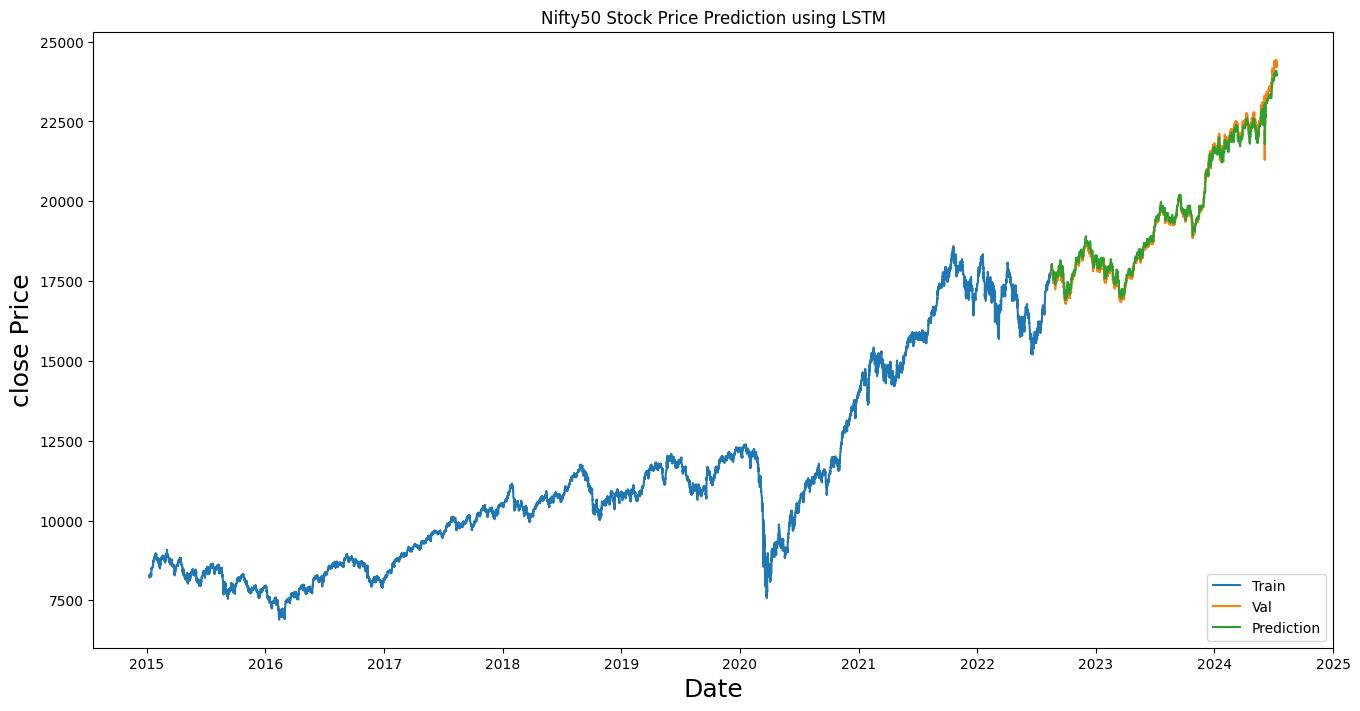

In [31]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plotting the results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Nifty50 Stock Price Prediction using LSTM')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('close Price', fontsize=18)
plt.legend(['Train', 'Val', 'Prediction'], loc='lower right')
plt.show()

In [43]:
print(predictions.shape)
print(y_test.shape)

(11716, 1)
(11716, 1)


Evaluation

In [45]:
# evaluation metrics 
mse = np.mean(((predictions - y_test) ** 2)) 
print("MSE", mse) 
print("RMSE", np.sqrt(mse)) 

MSE 12606.689077677927
RMSE 112.27951316993642
